In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os
import seaborn as sns

from tensorflow.keras.layers import Layer, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential, Model

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Image Aquisition

In [2]:
lok = './DuitRI/'

In [3]:
kls = []
n_gmbr = []
data = {'Denominasi Rp':[], 'N_gmbr':[]}

for i in os.listdir(lok+'/train'):
    n_gmbr.append(len(os.listdir(lok+'/train/'+i)))
    kls.append(i)
    
data['Denominasi Rp']+=kls
data['N_gmbr']+=n_gmbr

df= pd.DataFrame(data)
df


,Denominasi Rp,N_gmbr
0,10,100
1,100,100
2,20,98


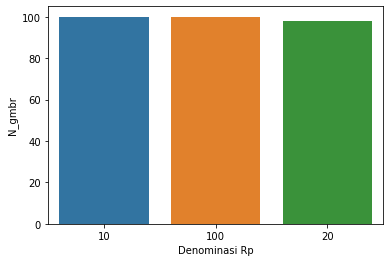

In [4]:
sns.barplot(x=df['Denominasi Rp'], y=df['N_gmbr'])

# Preprocessing

In [5]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                             rotation_range=20,
                                                             width_shift_range=0.2,
                                                             height_shift_range=0.2,
                                                             horizontal_flip=True,
                                                             validation_split=0.2)

In [6]:
train_ds = img_datagen.flow_from_directory(lok+'/train',
                                          subset='training',
                                          target_size=(150,150),
                                          batch_size=10)

val_ds = img_datagen.flow_from_directory(lok+'/train',
                                        subset='validation',
                                        target_size=(150,150),
                                        batch_size=10)

Found 239 images belonging to 3 classes.
Found 59 images belonging to 3 classes.


# Modeling with InceptionV3

In [7]:
from tensorflow.keras.applications import InceptionV3

ArsiInceptionV3 = tf.keras.models.Sequential([
    tf.keras.applications.InceptionV3(input_shape=(150,150,3),
                                     include_top=False,
                                     pooling='max',
                                     weights='imagenet'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='ReLU'),
    tf.keras.layers.Dense(64, activation='ReLU'),
    tf.keras.layers.Dense(32, activation='ReLU'),
    tf.keras.layers.Dense(8, activation='ReLU'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [8]:
ArsiInceptionV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                       metrics=['accuracy'])
ArsiInceptionV3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 8)                 2

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
CegahUnderorFit = EarlyStopping(monitor='val_accuracy',
                          patience=10,
                          min_delta=0.001,
                          mode='max',
                          restore_best_weights=True
                          )

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

ReduceLR= ReduceLROnPlateau(monitor='val_accuracy',
                           factor=0.3,
                           patience=8,
                           min_lr=0.001,
                           mode='auto',
                           verbose=1)

In [11]:
%%time
train_InceptionV3 = ArsiInceptionV3.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[CegahUnderorFit,ReduceLR])

Epoch 1/12
24/24 [==============================] - 33s 1s/step - loss: 0.9605 - accuracy: 0.5314 - val_loss: 0.9569 - val_accuracy: 0.5424 - lr: 1.0000e-04
Epoch 2/12
24/24 [==============================] - 22s 917ms/step - loss: 0.4396 - accuracy: 0.8536 - val_loss: 0.3744 - val_accuracy: 0.7627 - lr: 1.0000e-04
Epoch 3/12
24/24 [==============================] - 22s 911ms/step - loss: 0.1620 - accuracy: 0.9498 - val_loss: 0.1395 - val_accuracy: 0.9661 - lr: 1.0000e-04
Epoch 4/12
24/24 [==============================] - 22s 914ms/step - loss: 0.0773 - accuracy: 0.9749 - val_loss: 0.0435 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/12
24/24 [==============================] - 22s 926ms/step - loss: 0.0405 - accuracy: 0.9916 - val_loss: 0.0480 - val_accuracy: 0.9831 - lr: 1.0000e-04
Epoch 6/12
24/24 [==============================] - 22s 918ms/step - loss: 0.0813 - accuracy: 0.9791 - val_loss: 0.1125 - val_accuracy: 0.9661 - lr: 1.0000e-04
Epoch 7/12
24/24 [=========================

6/6 [==============================] - 1s 154ms/step - loss: 0.0019 - accuracy: 1.0000


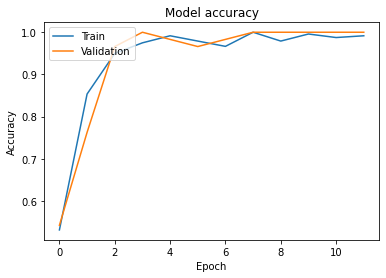

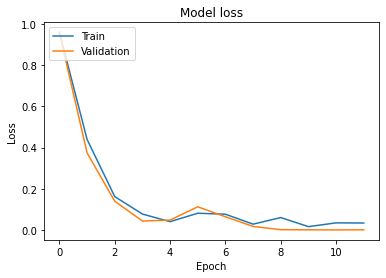

In [12]:
ArsiInceptionV3.evaluate(val_ds)
plt.plot(train_InceptionV3.history['accuracy'])
plt.plot(train_InceptionV3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_InceptionV3.history['loss'])
plt.plot(train_InceptionV3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluasi data uji Model InceptionV3

In [35]:
Kosongan_csv = './DuitRI/KosonganTest.csv'
Lok_ds = './DuitRI/Test/'

In [36]:
df_kosongan = pd.read_csv(Kosongan_csv)
nama_gmbr = df_kosongan['Nama_File']
df_kosongan.head()

,Nama_File,Label
0,20221107_134328,0
1,20221107_134330,0
2,20221107_134332,0
3,20221107_134334,0
4,20221107_134336,0


In [37]:
from tensorflow.keras.preprocessing.image import load_img

labels = []

for i in nama_gmbr:
    gmbar = load_img('./DuitRI/Test/'+str(i)+'.jpg', target_size=(150,150))
    gmbr = np.array(gmbar)
    gmbr = gmbr / 255.0
    gmbr = gmbr.reshape(1,150,150,3)
    label = ArsiInceptionV3.predict(gmbr)
    id_label = label[0].tolist()
    
    labels.append(id_label.index(max(id_label)))

1/1 [==============================] - 1s 1s/step


In [38]:
df_kosongan['Label'] = labels
df_kosongan.head(15)


,Nama_File,Label
0,20221107_134328,2
1,20221107_134330,2
2,20221107_134332,2
3,20221107_134334,2
4,20221107_134336,2
5,20221107_134338,2
6,20221107_134342,2
7,20221107_134344,2
8,20221107_134346,2
9,20221107_134350,2


In [39]:
df_prediksi_test = pd.DataFrame({'Nama_File':nama_gmbr,
                                'prediksi':labels})

In [40]:
df_baru = df_prediksi_test.replace(to_replace=[0,1,2], value=[10,100,20])

In [41]:
df_baru

,Nama_File,prediksi
0,20221107_134328,20
1,20221107_134330,20
2,20221107_134332,20
3,20221107_134334,20
4,20221107_134336,20
5,20221107_134338,20
6,20221107_134342,20
7,20221107_134344,20
8,20221107_134346,20
9,20221107_134350,20


In [42]:
df_baru.to_csv("DataPrediksiTest_InceptionV3.csv", index=False)

In [43]:
ds_aktual = pd.read_csv("./DuitRI/DataTest.csv")
ds_predik = pd.read_csv("./DataPrediksiTest_InceptionV3.csv")

In [44]:
ds_aktual

,Nama_File,Aktual
0,20221107_134328,20
1,20221107_134330,20
2,20221107_134332,20
3,20221107_134334,20
4,20221107_134336,20
5,20221107_134338,20
6,20221107_134342,20
7,20221107_134344,20
8,20221107_134346,20
9,20221107_134350,20


In [45]:
df_test_eval = pd.merge(
    ds_predik,
    ds_aktual,
    how="inner",
    on='Nama_File')

In [46]:
df_test_eval

,Nama_File,prediksi,Aktual
0,20221107_134328,20,20
1,20221107_134330,20,20
2,20221107_134332,20,20
3,20221107_134334,20,20
4,20221107_134336,20,20
5,20221107_134338,20,20
6,20221107_134342,20,20
7,20221107_134344,20,20
8,20221107_134346,20,20
9,20221107_134350,20,20


In [47]:
from sklearn.metrics import confusion_matrix
y_actual = df_test_eval['Aktual']
y_pred = df_test_eval['prediksi']
confusion_matrix(y_actual, y_pred)

array([[ 9,  0,  0],
       [ 0, 14,  0],
       [ 2,  0, 12]], dtype=int64)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

          10       0.82      1.00      0.90         9
          20       1.00      1.00      1.00        14
         100       1.00      0.86      0.92        14

    accuracy                           0.95        37
   macro avg       0.94      0.95      0.94        37
weighted avg       0.96      0.95      0.95        37



In [49]:
%pwd

'C:\\Users\\ASUS\\LatihanPython_DanielMorantha\\Orbit\\Practical\\Proyek Akhir\\Latihan\\YT'